## Define ROI

In [1]:
roi = 'Sweden'

## Define some paths

In [2]:
modelname = 'fulllinearmodel'
modelpath = '../models/'
fitpath = '/Users/aavattikutis/Documents/epidemicmodel/cccruns/fits/fit4/'
datapath = '../data/'
resultspath = "../results/"

## Init stuff

In [3]:
import pandas as pd
from datetime import datetime
from matplotlib.pyplot import *
import matplotlib
from numpy import *
import pystan
import pickle
import time
from io_sir import extract_samples

In [4]:
%matplotlib inline

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 18}

matplotlib.rc('font', **font)

In [5]:
def simpleaxis(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)


def fix_date(x):
    x = datetime.strftime(datetime.strptime(x, '%m/%d/%y'), '%m/%d/%y')
    return x

def fix_date_covidtrack(x):
    x = datetime.strftime(datetime.strptime(str(x), '%Y%m%d'), '%m/%d/%y')
    return x 

def getDF_covidtrack(roi):
    url = 'https://raw.githubusercontent.com/COVID19Tracking/covid-tracking-data/master/data/states_daily_4pm_et.csv'
    df = pd.read_csv(url)
    DF = pd.DataFrame(columns=['date', 
                               'cum_cases','cum_recover','cum_deaths', 
                               'new_cases', 'new_recover', 'new_deaths'])
    df = df[df['state']==roi]
    date = sort(df['date'].values)
    for i in range(len(date)):
        DF.loc[i] = pd.Series({
                             'date':fix_date_covidtrack(date[i]),
                             'cum_cases':df.loc[df['date']==date[i]]['positive'].values[0],
                             'cum_recover':df.loc[df['date']==date[i]]['recovered'].values[0],
                             'cum_deaths':df.loc[df['date']==date[i]]['death'].values[0],
                            })
    DF[['new_cases', 'new_recover', 'new_deaths']] = \
    DF[['cum_cases',  'cum_recover', 'cum_deaths']].diff()
    if isnan(DF.new_cases.values[0]):
        DF = DF.iloc[1:]
    return DF

def getDF_JHU(roi):
    url_confirmed = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"
    url_recovered = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv"
    url_deaths = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv"

    dfc = pd.read_csv(url_confirmed)
    dfr = pd.read_csv(url_recovered)
    dfd = pd.read_csv(url_deaths)


    DF = pd.DataFrame(columns=['date', 
                               'cum_cases','cum_recover','cum_deaths', 
                               'new_cases', 'new_recover', 'new_deaths'])

    date = dfc.columns[4:].values
    try:
        for i in range(len(date)):
          DF.loc[i] = pd.Series({
                                'date':fix_date(date[i]),
                                 'cum_cases':dfc.loc[(dfc['Country/Region']==roi)&(dfc['Province/State'].isnull())][date[i]].values[0],
                                 'cum_recover':dfr.loc[(dfr['Country/Region']==roi)&(dfc['Province/State'].isnull())][date[i]].values[0],
                                 'cum_deaths':dfd.loc[(dfd['Country/Region']==roi)&(dfc['Province/State'].isnull())][date[i]].values[0],
                                })
    except:
        for i in range(len(date)):
          DF.loc[i] = pd.Series({
                                'date':fix_date(date[i]),
                                 'cum_cases':sum(dfc.loc[(dfc['Country/Region']==roi)][date[i]].values),
                                 'cum_recover':sum(dfr.loc[(dfr['Country/Region']==roi)][date[i]].values),
                                 'cum_deaths':sum(dfd.loc[(dfd['Country/Region']==roi)][date[i]].values),
                                })

    DF[['new_cases', 'new_recover', 'new_deaths']] = \
    DF[['cum_cases',  'cum_recover', 'cum_deaths']].diff()

    # print(DF)
    if isnan(DF.new_cases.values[0]):
        DF = DF.iloc[1:]
    return DF

def plot_ts(ax,c,r,d,x,xticks_,xdates_):
    Clb = percentile(c,2.5,axis=0)
    Cm = percentile(c,50,axis=0)
    Cub = percentile(c,97.5,axis=0)

    Rlb = percentile(r,2.5,axis=0)
    Rm = percentile(r,50,axis=0)
    Rub = percentile(r,97.5,axis=0)

    Dlb = percentile(d,2.5,axis=0)
    Dm = percentile(d,50,axis=0)
    Dub = percentile(d,97.5,axis=0)

    mecolor = 'none'
    ax[0].plot(DF["new_cases"].values,'bo',ms=10, markeredgecolor=mecolor,label="cases data")
    ax[1].plot(DF["new_recover"].values,'gs',ms=10, markeredgecolor=mecolor,label="recovered data")
    ax[2].plot(DF["new_deaths"].values,'k^',ms=10, markeredgecolor=mecolor,label="deaths data")

    # print(c)
    ax[0].plot(x,Cm,color='b',lw=lw,label="case median fit")
    ax[0].fill_between(x,Clb,Cub,color='b',alpha=a)
    
    ax[1].plot(x,Rm,color='g',lw=lw,label="recovered median fit")
    ax[1].fill_between(x,Rlb,Rub,color='g',alpha=a)
    
    ax[2].plot(x,Dm,color='k',lw=lw,label="deaths median fit")
    ax[2].fill_between(x,Dlb,Dub,color='k',alpha=a)
    
    
    ax[0].plot(x,Clb,color='k')
    ax[0].plot(x,Cub,color='k')
    
    ax[1].plot(x,Rlb,color='k')
    ax[1].plot(x,Rub,color='k')
    
    ax[2].plot(x,Dlb,color='k')
    ax[2].plot(x,Dub,color='k')
    
    for i in range(3):
        ax[i].set_ylabel('counts-per-day')
        ax[i].set_xticks(xticks_)
        ax[i].set_xticklabels(xdates_)
        ax[i].axvline(tm,linestyle='dashed',color='k',label='mitigation')
        if i==0:
            ax[0].plot(0,0,linestyle='none',color='none', label='shaded: 95% C.I.')
        ax[i].legend(loc=2)
    
    
    ax[0].set_title('new cases per day')
    ax[1].set_title('new recovered per day')
    ax[2].set_title('new deaths per day')
    
    
    
    return

def plotXt(ax,Xt,y_,x,xticks_,xdates_,c):
    Xtlb = percentile(Xt,2.5,axis=0)
    Xtm = percentile(Xt,50,axis=0)
    Xtub = percentile(Xt,97.5,axis=0)
    
    ax.plot(x,Xtm,color=c,lw=lw,label="median")
    ax.fill_between(x,Xtlb,Xtub,color=c,alpha=a)
    ax.plot(x,Xtlb,color='k')
    ax.plot(x,Xtub,color='k')
#     ax.set_ylabel('secondary infections per infected')
    ax.set_xticks(xticks_)
    ax.set_xticklabels(xdates_)
#     ax.set_ylim((0,32))
    ax.set_yticks(y_)
    ax.axvline(tm,linestyle='dashed',color='k',label='mitigation')
    
    return

In [6]:
t0_notebook = time.time()

# Fit model

## Load data from url

In [7]:
if roi[:2]=='US':
    DF = getDF_covidtrack(roi.split('US_')[1])
else:
    DF = getDF_JHU(roi)

## Format data for missing values

In [8]:
# filter data frame by April 15th cutoff date

ind = DF.index[DF.date=='04/15/20'].values[0]
DF = DF[DF.index<=ind]

# get t0
t0 = DF.index[(DF.cum_cases>=10)&(DF.new_cases>0)].values[0]  # 
DF = DF[DF.index>=t0]

# assume zeros after t0 are missing, failure to report
yc = []
yr = []
yd = []

tc = []
tr = []
td = []

k = 0
for d in DF['date'].values:
    k += 1
    x = (DF.loc[DF.date==d]['new_cases'].values[0])
    if isfinite(x) and x>0:
        yc.append(int(x))
        tc.append(k)
    x = (DF.loc[DF.date==d]['new_recover'].values[0])
    if isfinite(x) and x>0:
        yr.append(int(x))
        tr.append(k)
    x = (DF.loc[DF.date==d]['new_deaths'].values[0])
    if isfinite(x) and x>0:
        yd.append(int(x))
        td.append(k)

## Format data for Stan

In [9]:
stan_data = {}
stan_data['n_scale'] = 1000  # use this instead of population
stan_data['n_difeq'] = 5

stan_data['n_obs'] = len(DF)
stan_data['ts'] = arange(t0,DF.index.values[-1]+1)

stan_data['y_c'] = yc
stan_data['n_obs_c'] = len(yc)
stan_data['ts_c'] = tc

if len(yr)>0:
    stan_data['y_r'] = yr
    stan_data['n_obs_r'] = len(yr)
    stan_data['ts_r'] = tr
else:
    stan_data['y_r'] = [-1]
    stan_data['n_obs_r'] = 1
    stan_data['ts_r'] = [-1]

stan_data['y_d'] = yd
stan_data['n_obs_d'] = len(yd)
stan_data['ts_d'] = td

try:
    dfm = pd.read_csv(datapath + 'mitigationprior.csv')
    tmdate = dfm.loc[dfm.region == roi, 'date'].values[0]
    tm = np.where(DF["date"] == tmdate)[0][0]
except:
    tm = t0 + 10

stan_data['tm'] = tm

### Compile, load Stan model

In [10]:
try:
    samples = extract_samples(fitpath, modelpath, modelname, roi, 1)
except: #for US that were not run due to missing data 
    samples = extract_samples(fitpath, modelpath, modelname, 'US_NY', 1)

## COMMENT out (1) if pickle exists

In [11]:
## compile model 
##(1)
# stanmodel = pystan.StanModel(file="../models/linearmodel_missing.stan")#, verbose=True)
# import pickle
# with open("stanmodel_missing_linear.pkl", "wb") as f:
#     pickle.dump(stanmodel, f, protocol=-1)
    
## (2)
stanmodel = pickle.load(open('stanmodel_missing_linear.pkl', 'rb'))

### Get initial values from prior run

In [12]:
theta_ = ['f1','f2','sigmar','sigmad','sigmau','q','mbase','mlocation','extra_std','cbase','clocation','n_pop']
n_chains = 4 # new chains (see sampler)
ind_ = arange(len(samples))
random.shuffle(ind_)
init_ = [] # get initial parameters by randomly sampling old
for i in range(n_chains): 
    initi = {}
    for theta in theta_:
        try:
            initi[theta] = samples[theta][ind_[i]]
        except:
            pass
    init_.append(initi)

### Run sampler

In [13]:
control = {'adapt_delta': 0.95}
n_warmups = 500
n_iter = 2000
n_thin = 1

fit = stanmodel.sampling(
                        data = stan_data, 
                        init = init_, 
                        control = control,
                        chains = n_chains,
                        chain_id = arange(n_chains),
                        warmup = n_warmups, 
                        iter = n_iter,
                        thin = n_thin
                           )

In [14]:
print(fit)

Inference for Stan model: anon_model_9075c1092b6281a471ea918c8f48b6b8.
4 chains, each with iter=2000; warmup=500; thin=1; 
post-warmup draws per chain=1500, total post-warmup draws=6000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
f1            22.79    0.31  15.21   3.74   11.7  19.37  30.21  61.18   2397    1.0
f2             0.86    0.01   0.52    0.3   0.56   0.71   0.97   2.29   1472    1.0
sigmar         0.05  6.6e-4   0.02   0.02   0.03   0.04   0.05    0.1   1230    1.0
sigmad         0.01  8.1e-5 3.1e-3 9.6e-3   0.01   0.01   0.02   0.02   1489    1.0
sigmau         0.08  1.4e-3   0.07   0.02   0.04   0.06    0.1   0.26   2268    1.0
mbase          0.24  3.1e-3   0.12   0.07   0.16   0.22   0.29   0.55   1497    1.0
mlocation     39.67    2.07  26.25  12.89  34.47  38.02  41.26   74.2    160   1.03
extra_std      0.63  1.1e-3   0.06   0.52   0.59   0.63   0.67   0.76   3141    1.0
cbase          3.42     0.1   3.91   0.15    0.8   2.08 

### Run projections

In [15]:
## required
stan_data['c0'] = DF.new_cases.values[0]

# # optional for extrapolation
# stan_data['n_obs'] = len(DF) + 60
# stan_data['ts'] = arange(t0,DF.index.values[-1]+1 + 60)




## COMMENT out (1) if pickle exists

In [16]:
## compile model 
##(1)
# stanproj = pystan.StanModel(file="../models/linearmodel_missing_projections.stan")#, verbose=True)
# import pickle
# with open("stanmodel_missing_projections_linear.pkl", "wb") as f:
#     pickle.dump(stanproj, f, protocol=-1)

##(2)
stanproj = pickle.load(open('stanmodel_missing_projections_linear.pkl', 'rb'))

In [17]:
samples = fit.extract()

In [18]:
nobs = stan_data['n_obs']
n = n_chains*(n_iter - n_warmups)
c = np.zeros((n,nobs))
r = np.zeros((n,nobs))
d = np.zeros((n,nobs))

Rt = np.zeros((n,nobs))
CARt = np.zeros((n,nobs))
IFRt = np.zeros((n,nobs))

k = -1
badcount = 0
for i in range(n):
    init_ = {}
    for theta in theta_:
        try:
            init_[theta] = samples[theta][i]
        except:
            pass
    predict = stanproj.sampling(data=stan_data,iter=1,init=[init_], chains=1, algorithm = "Fixed_param")
    if ((sum(np.isnan(predict.extract()['lambda'][0,:,0]))>0) or 
    (sum(np.isnan(predict.extract()['lambda'][0,:,1]))>0) or 
    (sum(np.isnan(predict.extract()['lambda'][0,:,0]))>0)):
#         print('bad')
        badcount += 1
    else:
        k += 1
        c[k,:] = predict.extract()['lambda'][0,:,0]
        r[k,:] = predict.extract()['lambda'][0,:,1]
        d[k,:] = predict.extract()['lambda'][0,:,2]
        Rt[k,:] = predict.extract()['Rt'][0,:]
        CARt[k,:] = predict.extract()['car'][0,:]
        IFRt[k,:] = predict.extract()['ifr'][0,:]
        
print(badcount/n)

0.0


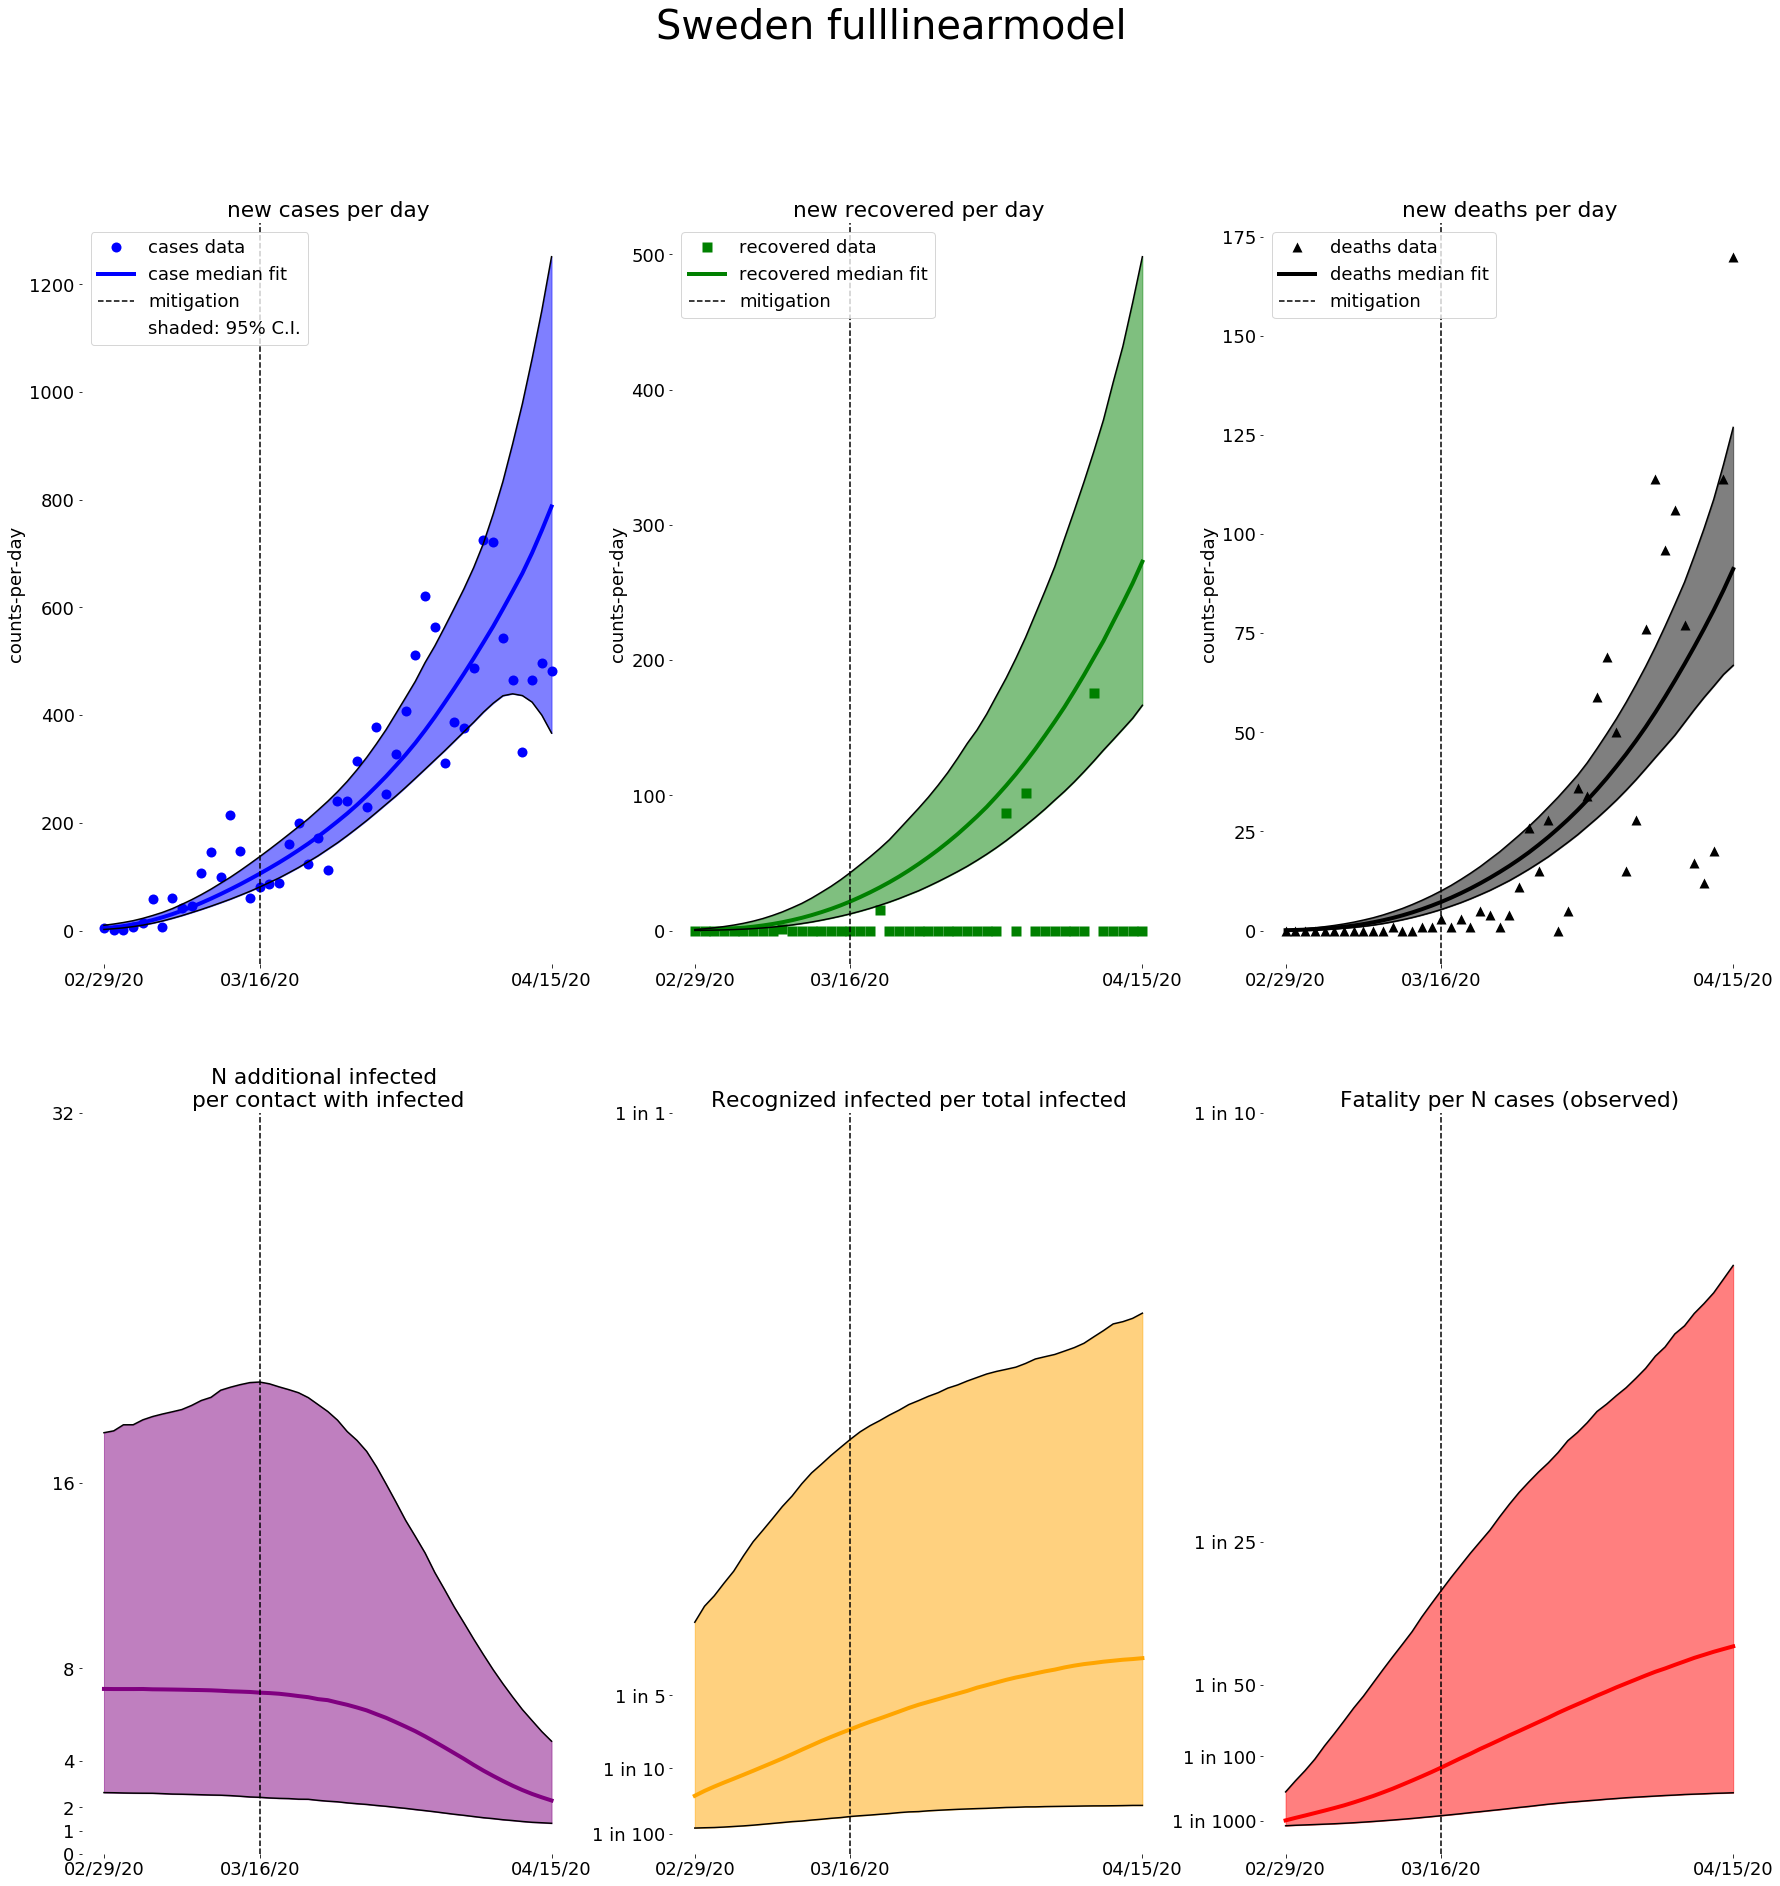

In [19]:
f,ax = subplots(2,3,figsize=(30,30))
ax = ax.flatten()
a = 0.5
lw = 4
x = array(stan_data['ts'])-t0
xticks_ = array([0,len(x)-1] + [tm])
xdates_ = DF['date'].values[xticks_]
plot_ts(ax[:3],c,r,d,x,xticks_,xdates_)


ax[3].set_title('N additional infected \nper contact with infected')
y_ = [0,1,2,4,8,16,32]
plotXt(ax[3],Rt,y_,x,xticks_,xdates_,(128/255.,0,128/255.))

y_ = [0.01,0.1,0.2,1]
ax[4].set_title('Recognized infected per total infected')
plotXt(ax[4],CARt,y_,x,xticks_,xdates_,'orange')
ylab_ = []
for i in y_:
    ylab_.append('1 in '+str(int(1/i)))
ax[4].set_yticklabels(ylab_)

y_ = array([0.001,0.01,0.02,0.04,0.1])
ax[5].set_title('Fatality per N cases (observed)')
plotXt(ax[5],IFRt,y_,x,xticks_,xdates_,'red')
ylab_ = []
for i in y_:
    ylab_.append('1 in '+str(int(1/i)))
ax[5].set_yticklabels(ylab_)

for i in range(len(ax)):
    simpleaxis(ax[i])

suptitle(roi + ' ' + modelname, fontsize=40)
savefig(resultspath + roi+'_'+modelname+'_positivesonly.png',dpi=200)
